#Installation and Preparation

**This section handles the initial setup, including installing necessary libraries, importing modules, configuring PyTorch for reproducibility, and setting up the Kaggle API for dataset access.**



---



##Installs

In [ ]:
!pip install -q pandas numpy matplotlib seaborn scikit-learn pillow tqdm opencv-python-headless ydata-profiling torch torchvision torchaudio
!pip install -q kaggle

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.1 MB/s eta 0:00:00
  

In [ ]:
!pip install torchinfo

##Imports

In [ ]:
from PIL import Image  # Add this import


In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import os
import zipfile
import shutil
from tqdm.notebook import tqdm # Use tqdm.notebook for Colab progress bars
import torch
import torch.nn as nn
import torchvision.transforms as T_vision # Renamed to avoid conflictfrom PIL import Image
import re
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.amp # For mixed precision
from google.colab import files
from ydata_profiling import ProfileReport
import time # For timing operations
from torchvision import transforms as torchvision_transforms # Explicitly for original augs if needed
from torchinfo import summary

# Check Torch version and CUDA availability
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")

# Set random seed for reproducibility (optional but recommended)
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # Set to False for deterministic runs

PyTorch Version: 2.6.0+cu124
CUDA Available: True
CUDA Device Name: Tesla T4


##Setting up Kaggle and dataset


**This section focuses on downloading the BreaKHis dataset from Kaggle, unzipping it, and reorganizing the image files into a more structured format (separate folders for 'benign' and 'malignant' classes).**

In [ ]:
print("Setting up Kaggle...")
try:
    # Attempt to remove existing config if it exists
    os.remove('/root/.kaggle/kaggle.json')
except OSError:
    pass # Ignore if file doesn't exist

# Upload kaggle.json
try:
    uploaded = files.upload()

    if 'kaggle.json' not in uploaded:
        raise FileNotFoundError("kaggle.json not found in uploaded files.")

    # Create directory and set permissions
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("Kaggle API configured successfully.")

except Exception as e:
    print(f"Kaggle setup failed: {e}")
    print("Please ensure you upload your kaggle.json file correctly.")

Setting up Kaggle...


Saving kaggle.json to kaggle.json
Kaggle API configured successfully.


In [ ]:
print("Downloading BreaKHis dataset...")
!kaggle datasets download -d ambarish/breakhis -q # Added -q for quieter download
print("Unzipping dataset...")
start_time = time.time()
!unzip -q breakhis.zip -d breakhis # Added -q for quieter unzip
end_time = time.time()
print(f"Dataset downloaded and unzipped in {end_time - start_time:.2f} seconds.")

Dataset URL: https://www.kaggle.com/datasets/ambarish/breakhis
License(s): unknown
Unzipping dataset...
Dataset downloaded and unzipped in 56.27 seconds.


In [ ]:
source_base_dir = '/content/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast'
# Define the new directory to store organized images
destination_base_dir = '/content/organized_images'
# Create destination folders for benign and malignant if they don't exist
os.makedirs(os.path.join(destination_base_dir, 'benign'), exist_ok=True)
os.makedirs(os.path.join(destination_base_dir, 'malignant'), exist_ok=True)


The original BreaKHis dataset has a nested directory structure. This function copies all .png images from the source benign and malignant subfolders into new, flat organized_images/benign and organized_images/malignant directories.

In [ ]:
def copy_images(source_path, destination_path):
    for root, dirs, files in os.walk(source_path):
        for file in files:
            if file.lower().endswith('.png'):
                src_file = os.path.join(root, file)
                dst_file = os.path.join(destination_path, file)

                # Handle potential duplicate filenames
                counter = 1
                while os.path.exists(dst_file):
                    name, ext = os.path.splitext(file)
                    dst_file = os.path.join(destination_path, f"{name}_{counter}{ext}")
                    counter += 1

                shutil.copy2(src_file, dst_file)

In [ ]:
# Copy benign images
print("Copying benign images...")
benign_source = os.path.join(source_base_dir, 'benign')
copy_images(benign_source, os.path.join(destination_base_dir, 'benign'))

# Copy malignant images
print("Copying malignant images...")
malignant_source = os.path.join(source_base_dir, 'malignant')
copy_images(malignant_source, os.path.join(destination_base_dir, 'malignant'))

print("Done! All images have been organized.")

Copying benign images...
Copying malignant images...
Done! All images have been organized.


In [ ]:
# List the contents of the new benign and malignant directories
benign_images = os.listdir(os.path.join(destination_base_dir, 'benign'))
malignant_images = os.listdir(os.path.join(destination_base_dir, 'malignant'))
print(f"Benign images: {len(benign_images)}")
print(f"Malignant images: {len(malignant_images)}")

Benign images: 2480
Malignant images: 5429


#MetaData Generation

**This section is responsible for parsing filenames to extract rich metadata for each image (label, tumor class, subtype, magnification, slide ID) and compiling it into a structured CSV file.**



---



SUBTYPE_MAP: A dictionary mapping abbreviation codes from filenames (e.g., 'A', 'F', 'DC') to full subtype names (e.g., 'Adenosis', 'Fibroadenoma', 'Ductal Carcinoma'). This standardizes subtype information.

extract_subtype function: Uses regular expressions to parse subtype codes from filenames, accommodating both single-letter and two-letter codes.

create_metadata_csv function:
Iterates through the organized image directories.
Uses Regular Expressions (re.search) to robustly extract:
tumor_class (B or M)
magnification (e.g., 40X, 100X)
slide_id (patient identifier, crucial for group-based data splitting)
subtype (using extract_subtype)
Creates a full_class_name for potential finer-grained classification tasks (though the current project focuses on binary benign/malignant).
Appends this information to a list, which is then converted into a Pandas DataFrame.

In [ ]:
SUBTYPE_MAP = {
    'B': {
        'A': 'Adenosis',
        'F': 'Fibroadenoma',
        'TA': 'Tubular Adenoma',
        'PT': 'Phyllodes Tumor'
    },
    'M': {
        'DC': 'Ductal Carcinoma',
        'LC': 'Lobular Carcinoma',
        'MC': 'Mucinous Carcinoma',
        'PC': 'Papillary Carcinoma'
    }
}
def extract_subtype(file_name, tumor_class):
    # Try long code first (like TA, PT, etc.)
    long_code_match = re.search(r'SOB_[BM]_([A-Z]{2})-', file_name)
    if long_code_match:
        code = long_code_match.group(1)
        return SUBTYPE_MAP.get(tumor_class, {}).get(code, "Unknown")

    # Then try short code (like A, F, etc.)
    short_code_match = re.search(r'SOB_[BM]_([A-Z])-', file_name)
    if short_code_match:
        code = short_code_match.group(1)
        return SUBTYPE_MAP.get(tumor_class, {}).get(code, "Unknown")

    return "Unknown"

def create_metadata_csv(image_dir, label):
    data = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith(".png"):
                path = os.path.join(root, file)

                # Extract tumor class (B or M)
                tumor_class_match = re.search(r'SOB_([BM])_', file)
                tumor_class = tumor_class_match.group(1) if tumor_class_match else "Unknown"

                # Extract magnification
                mag_match = re.search(r'-(\d{2,3})-\d+\.png$', file)
                magnification = f"{mag_match.group(1)}X" if mag_match else "Unknown"

                # Extract slide ID
                slide_match = re.search(r'-(\d{2}-\d+)', file)
                slide_id = slide_match.group(1) if slide_match else "Unknown"

                # Subtype
                subtype = extract_subtype(file, tumor_class)

                # Full class name
                full_class_name = f"{label}_{subtype.replace(' ', '_')}"

                data.append({
                    "image_path": path,
                    "label": label,
                    "tumor_class": tumor_class,
                    "subtype": subtype,
                    "magnification": magnification,
                    "slide_id": slide_id,
                    "full_class_name": full_class_name
                })
    return pd.DataFrame(data)


DataFrame Concatenation: benign_df and malignant_df are combined into a single metadata_df.

slide_id Validation: An essential check is performed to ensure all images have a valid slide_id extracted. If any are "Unknown," an error is raised because GroupShuffleSplit relies on valid slide IDs to prevent data leakage.

CSV Export: The final metadata is saved to breakhis_metadata.csv for persistence and reusability.

In [ ]:
benign_df = create_metadata_csv('/content/organized_images/benign', 'benign')
malignant_df = create_metadata_csv('/content/organized_images/malignant', 'malignant')

metadata_df = pd.concat([benign_df, malignant_df], ignore_index=True)
print("\nValidating slide_id extraction...")
unknown_slides = metadata_df[metadata_df['slide_id'] == 'Unknown']
if not unknown_slides.empty:
    print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"ERROR: Found {len(unknown_slides)} images with 'Unknown' slide_id!")
    print("Sample problematic filenames:")
    print(unknown_slides['image_path'].apply(os.path.basename).head())
    print("Please fix the `slide_id` extraction regex in `create_metadata_csv` or file organization.")
    print("Group splitting requires valid slide IDs for all images.")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    # Optionally raise an error:
    raise ValueError("Cannot proceed with group splitting due to unknown slide IDs.")
else:
    print("✅ slide_id extraction appears successful for all images.")
    print(f"   Total unique slide IDs found: {metadata_df['slide_id'].nunique()}")
metadata_df.to_csv("breakhis_metadata.csv", index=False)
print("\nMetadata CSV saved ('breakhis_metadata.csv'). Sample:")
print(metadata_df.head())
print(f"Total images in metadata: {len(metadata_df)}")


Validating slide_id extraction...
✅ slide_id extraction appears successful for all images.
   Total unique slide IDs found: 70

Metadata CSV saved ('breakhis_metadata.csv'). Sample:
                                          image_path   label tumor_class  \
0  /content/organized_images/benign/SOB_B_F-14-23...  benign           B   
1  /content/organized_images/benign/SOB_B_TA-14-2...  benign           B   
2  /content/organized_images/benign/SOB_B_A-14-22...  benign           B   
3  /content/organized_images/benign/SOB_B_PT-14-2...  benign           B   
4  /content/organized_images/benign/SOB_B_PT-14-2...  benign           B   

           subtype magnification  slide_id         full_class_name  
0     Fibroadenoma           40X  14-23060     benign_Fibroadenoma  
1  Tubular Adenoma          200X  14-21978  benign_Tubular_Adenoma  
2         Adenosis          400X  14-22549         benign_Adenosis  
3  Phyllodes Tumor          100X  14-21998  benign_Phyllodes_Tumor  
4  Phyllodes Tu

#Exploratory Data Analysis (EDA)

**This section visualizes key aspects of the dataset using the generated metadata to understand distributions and potential biases.**

Performing EDA...


<ipython-input-12-f7bedb06a3c8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=metadata_df, x='label', palette='Set2', order=metadata_df['label'].value_counts().index)


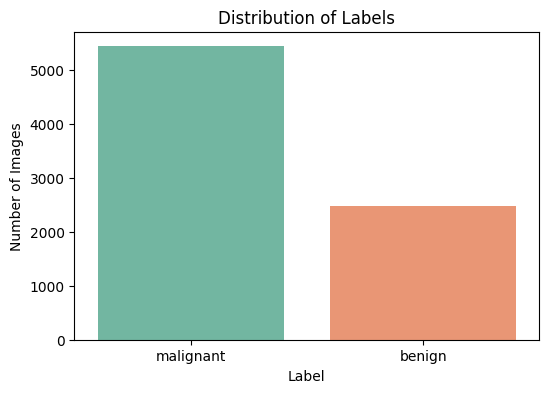

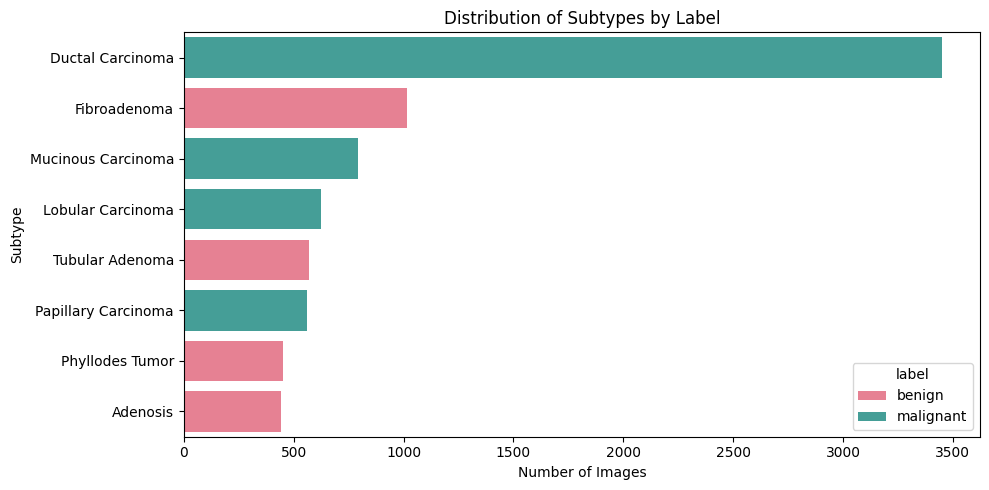

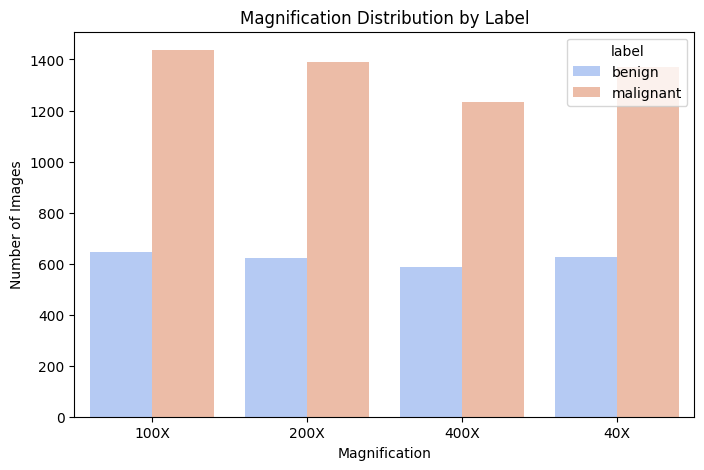

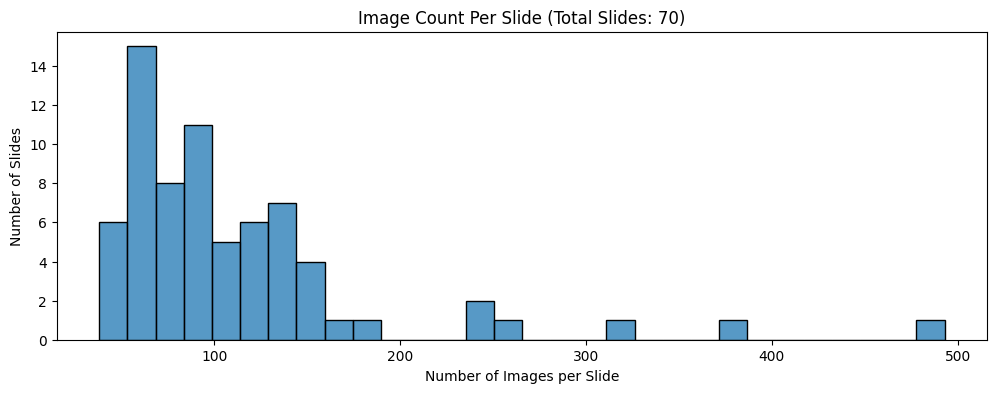


Generating ydata-profiling report (this may take some time)...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
print("Performing EDA...")

# Distribution of Labels
plt.figure(figsize=(6, 4))
sns.countplot(data=metadata_df, x='label', palette='Set2', order=metadata_df['label'].value_counts().index)
plt.title("Distribution of Labels")
plt.ylabel("Number of Images")
plt.xlabel("Label")
plt.show()

# Distribution of Subtypes
plt.figure(figsize=(10, 5))
sns.countplot(data=metadata_df, y='subtype', hue='label', palette='husl', order=metadata_df['subtype'].value_counts().index)
plt.title("Distribution of Subtypes by Label")
plt.xlabel("Number of Images")
plt.ylabel("Subtype")
plt.tight_layout()
plt.show()

# Magnification Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=metadata_df, x='magnification', hue='label', palette='coolwarm', order=sorted(metadata_df['magnification'].unique()))
plt.title("Magnification Distribution by Label")
plt.ylabel("Number of Images")
plt.xlabel("Magnification")
plt.show()

# Image Count Per Slide
plt.figure(figsize=(12, 4))
slide_counts = metadata_df['slide_id'].value_counts()
sns.histplot(slide_counts, bins=min(30, len(slide_counts)), kde=False)
plt.title(f"Image Count Per Slide (Total Slides: {len(slide_counts)})")
plt.xlabel("Number of Images per Slide")
plt.ylabel("Number of Slides")
plt.show()

# Generate Profiling Report (can take a minute or two)
print("\nGenerating ydata-profiling report (this may take some time)...")
profile = ProfileReport(metadata_df, title="BreaKHis Metadata Report")
profile.to_notebook_iframe()

In [ ]:
metadata_df.head()

,image_path,label,tumor_class,subtype,magnification,slide_id,full_class_name
0,/content/organized_images/benign/SOB_B_F-14-23...,benign,B,Fibroadenoma,40X,14-23060,benign_Fibroadenoma
1,/content/organized_images/benign/SOB_B_TA-14-2...,benign,B,Tubular Adenoma,200X,14-21978,benign_Tubular_Adenoma
2,/content/organized_images/benign/SOB_B_A-14-22...,benign,B,Adenosis,400X,14-22549,benign_Adenosis
3,/content/organized_images/benign/SOB_B_PT-14-2...,benign,B,Phyllodes Tumor,100X,14-21998,benign_Phyllodes_Tumor
4,/content/organized_images/benign/SOB_B_PT-14-2...,benign,B,Phyllodes Tumor,100X,14-21998,benign_Phyllodes_Tumor


#PreProcessing

**This section prepares the data for model training, including label encoding, defining image augmentation pipelines, and setting up the PyTorch device.**



---



**Label Encoding** (LabelEncoder): Converts string labels ('benign', 'malignant') into numerical format (0, 1) suitable for the model. Includes a fallback to fit the encoder if it hasn't been fitted, which is good for notebook re-runnability.

**ImageNet Mean/Std**: Standard ImageNet mean and standard deviation values are defined for normalizing image tensors. This is common practice when using pre-trained models.

**get_augmentation_tv** function (Torchvision-based Augmentations):
Defines phase-dependent augmentations. This is a sophisticated strategy where stronger augmentations (more aggressive ColorJitter, larger RandomRotation, RandomAffine) are used in Phase 1 (head training), and milder augmentations are used in later phases (Phase 2/3, backbone fine-tuning). The rationale is that stronger augmentations help prevent overfitting when only the head is training, while milder ones are used during fine-tuning to avoid distorting the learned features too much.

**Augmentations** Used: Resize, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, RandomRotation, RandomAffine, ToTensor, Normalize (ImageNet stats), RandomErasing. This is a comprehensive set of common and effective augmentations for image classification.

test_transform_tv: A simpler augmentation pipeline for validation and testing, typically involving only resizing, ToTensor, and Normalize, to ensure consistent evaluation.

In [ ]:
print("Preprocessing and defining transforms...")
le = LabelEncoder()
if not hasattr(le, 'classes_') or le.classes_ is None:
    # This is a fallback, ensure 'le' is properly fitted on your 'label' column from metadata_df
    print("Warning: LabelEncoder 'le' not properly fitted or classes not found. Fitting now based on 'label' column if metadata_df exists.")
    if 'metadata_df' in globals() and not metadata_df.empty and 'label' in metadata_df.columns: # Added check for 'label' column
        # Ensure 'le' is an instance of LabelEncoder
        if not isinstance(le, LabelEncoder):
            le = LabelEncoder()
        metadata_df['encoded_label'] = le.fit_transform(metadata_df['label']) # Fit and transform
        print(f"Labels encoded. Mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")
    else:
        # This error message is more accurate now if metadata_df is problematic
        raise ValueError("metadata_df not found, empty, or missing 'label' column, or 'le' is not a LabelEncoder instance. Cannot fit LabelEncoder.")
print(f"Number of classes: {len(le.classes_)}")

# Define ImageNet mean and std for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def get_augmentation_tv(phase, mean_vals, std_vals): # tv for torchvision
    """Phase-dependent augmentation strength using torchvision.transforms."""
    base_transforms = [
        T_vision.Resize(256), # Use T_vision
        T_vision.RandomCrop(224),
        T_vision.RandomHorizontalFlip(),
        T_vision.RandomVerticalFlip(),
    ]

    if phase == 1:  # Stronger aug early
        print("Using stronger augmentations for Phase 1.")
        specific_transforms = [
            T_vision.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            T_vision.RandomRotation(45),
            T_vision.RandomAffine(degrees=0, translate=(0.15, 0.15)), # Ensure degrees=0 if RandomRotation is separate
        ]
        final_transforms = [
            T_vision.ToTensor(),
            T_vision.Normalize(mean=mean_vals, std=std_vals),
            T_vision.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0)
        ]
    else:  # Less aggressive later (Phase 2 and 3)
        print("Using milder augmentations for Phase 2/3.")
        specific_transforms = [
            T_vision.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
            T_vision.RandomRotation(30),
        ]
        final_transforms = [
            T_vision.ToTensor(),
            T_vision.Normalize(mean=mean_vals, std=std_vals),
            T_vision.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0)
        ]

    return T_vision.Compose(base_transforms + specific_transforms + final_transforms)

# Test transform remains simpler
test_transform_tv = T_vision.Compose([
    T_vision.Resize((224, 224)),
    T_vision.ToTensor(),
    T_vision.Normalize(mean=mean, std=std)
])

print("Augmentation functions defined.")

Preprocessing and defining transforms...
Labels encoded. Mapping: {'benign': np.int64(0), 'malignant': np.int64(1)}
Number of classes: 2
Augmentation functions defined.


**Device Configuration** (torch.device): Sets the computation device to CUDA (GPU) if available, otherwise CPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#Custom Dataset and Data Splitting

**This section defines a custom PyTorch Dataset class to load and process images, and then splits the metadata into training, validation, and test sets using a group-aware strategy.**



---



**CustomDataset class:**
Inherits from torch.utils.data.Dataset.

Takes metadata and a transform function as input.

Includes path verification to check for missing image files during initialization.

__getitem__: Loads an image using Pillow, converts to RGB, applies the provided transformations.


In [ ]:
class CustomDataset(Dataset):
    """Custom Dataset for loading BreaKHis images."""
    def __init__(self, metadata, transform=None):
        self.metadata = metadata.reset_index(drop=True) # Reset index after split for iloc robustness
        self.transform = transform
        # --- Pre-check image paths ---
        print(f"Verifying paths for {len(self.metadata)} dataset entries...")
        start_verify = time.time()
        self.metadata['path_exists'] = self.metadata['image_path'].apply(os.path.exists)
        invalid_paths = self.metadata[~self.metadata['path_exists']]
        if not invalid_paths.empty:
             print(f"WARNING: Found {len(invalid_paths)} invalid image paths in this dataset split!")
             print(invalid_paths[['image_path']].head())
             #Option: Filter out invalid paths
             self.metadata = self.metadata[self.metadata['path_exists']].reset_index(drop=True)
             print(f"Filtered dataset size: {len(self.metadata)}")
        print(f"Path verification took {time.time() - start_verify:.2f}s")


    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Use iloc for robust index-based access after potential shuffling/splitting
        img_path = self.metadata.iloc[idx]['image_path']
        label = self.metadata.iloc[idx]['encoded_label']

        try:
            # Open image and ensure it's RGB
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
             print(f"ERROR: Image file not found at path: {img_path} for index {idx}")
             # Return placeholder or raise error - raising recommended during debugging
             raise FileNotFoundError(f"Image file not found: {img_path}")
        except Exception as e:
             print(f"ERROR: Failed to load image {img_path}. Error: {e}")
             # Consider returning None or placeholder if you want training to continue
             raise e # Re-raise the exception

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label

print("CustomDataset class defined.")

CustomDataset class defined.


**Data Splitting** (GroupShuffleSplit):
This is a critical choice for medical imaging datasets like BreaKHis where multiple images (patches) can come from the same patient (slide).

It ensures that all images from a particular slide_id (patient) are entirely within one split (train, validation, or test), preventing data leakage and leading to a more realistic evaluation of the model's generalization capabilities.

A two-step split is performed: first to separate the test set, then to split the remaining data into training and validation sets. The proportions (test_size=0.15, test_size=0.15/0.85) are reasonable.
An assert statement verifies that there's no slide ID leakage between the sets.


In [ ]:
print("--- Preparing Data Splits (Train/Validation/Test) ---")
# We need a dedicated validation set for early stopping during phased training.
# Test set will be evaluated once at the very end.
# Split 1: Separate test set (e.g., 15%)
gss_test = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
groups = metadata_df['slide_id'].values
train_val_idx, test_idx = next(gss_test.split(metadata_df, metadata_df['encoded_label'], groups))

train_val_df = metadata_df.iloc[train_val_idx]
test_df = metadata_df.iloc[test_idx]

# Split 2: Separate train and validation sets from train_val_df (e.g., val_size approx 15% of original -> 0.15/0.85 of train_val_df)
gss_val = GroupShuffleSplit(n_splits=1, test_size=0.15/0.85, random_state=SEED)
groups_train_val = train_val_df['slide_id'].values
train_idx, val_idx = next(gss_val.split(train_val_df, train_val_df['encoded_label'], groups_train_val))

train_df = train_val_df.iloc[train_idx].copy()
val_df = train_val_df.iloc[val_idx].copy()

print(f"Training set: {len(train_df)} images, {train_df['slide_id'].nunique()} slides")
print(f"Validation set: {len(val_df)} images, {val_df['slide_id'].nunique()} slides")
print(f"Test set: {len(test_df)} images, {test_df['slide_id'].nunique()} slides")

# Verify no slide leakage
train_slides = set(train_df['slide_id'])
val_slides = set(val_df['slide_id'])
test_slides = set(test_df['slide_id'])
assert train_slides.isdisjoint(val_slides), "Leakage between train and val!"
assert train_slides.isdisjoint(test_slides), "Leakage between train and test!"
assert val_slides.isdisjoint(test_slides), "Leakage between val and test!"
print("✅ No slide_id leakage between train, validation, and test sets.")

--- Preparing Data Splits (Train/Validation/Test) ---
Training set: 5437 images, 48 slides
Validation set: 1120 images, 11 slides
Test set: 1352 images, 11 slides
✅ No slide_id leakage between train, validation, and test sets.


#Class Imbalance Handling and DataLoader Configuration

**This section addresses class imbalance in the training data and configures PyTorch DataLoaders for efficient batching.**



---



**Class Weights** for Loss Function (compute_class_weight): Calculates weights to penalize misclassifications of the minority class more heavily in the loss function. Uses 'balanced' mode from sklearn.

**Weighted Random Sampler** (WeightedRandomSampler): For the training DataLoader, this sampler ensures that each batch contains a more balanced representation of classes by oversampling the minority class and undersampling the majority class. This helps the model see examples from all classes more equitably during training.

In [ ]:
# --- Handling Class Imbalance (for WeightedRandomSampler on training set) ---
print("Calculating class weights for loss function (overall dataset)...")
class_weights_values = compute_class_weight('balanced',
                                     classes=np.unique(metadata_df['encoded_label']),
                                     y=metadata_df['encoded_label'])
loss_weights = torch.tensor(class_weights_values, dtype=torch.float).to(device)
print(f"Class weights for loss: {loss_weights.cpu().numpy()}")

print("Calculating sample weights for Training DataLoader sampler...")
label_counts_train = train_df['encoded_label'].value_counts()
train_sampler = None
if not label_counts_train.empty and len(label_counts_train) >= len(le.classes_):
    sample_weights_train = train_df['encoded_label'].apply(lambda x: 1.0 / label_counts_train[x]).values
    train_sampler = WeightedRandomSampler(weights=torch.DoubleTensor(sample_weights_train),
                                          num_samples=len(train_df), replacement=True)
    print("WeightedRandomSampler created for training DataLoader.")
else:
    print("Warning: Not enough classes or empty train_df for WeightedRandomSampler. Using standard shuffle.")

Calculating class weights for loss function (overall dataset)...
Class weights for loss: [1.5945565  0.72840303]
Calculating sample weights for Training DataLoader sampler...
WeightedRandomSampler created for training DataLoader.


**DataLoader** Configuration:
BATCH_SIZE: Set to 32, a common choice.

NUM_WORKERS: Set to 2 for parallel data loading. This value can be tuned based on the system's CPU cores.

pin_memory=True: Can speed up data transfer from CPU to GPU if CUDA is used.

The training DataLoader uses the train_sampler if created, otherwise standard shuffling. Validation and test DataLoaders use shuffle=False for consistent evaluation.

In [ ]:
# --- DataLoaders ---
# Note: train_dataset will be re-created at phase transitions if augmentations change
BATCH_SIZE = 32
NUM_WORKERS = 2

# Initial transform for phase 1
current_train_transform = get_augmentation_tv(phase=1, mean_vals=mean, std_vals=std)
train_dataset = CustomDataset(train_df, transform=current_train_transform)
val_dataset = CustomDataset(val_df, transform=test_transform_tv) # Val uses test_transform
test_dataset = CustomDataset(test_df, transform=test_transform_tv) # Test uses test_transform

train_dataloader_args = {'batch_size': BATCH_SIZE, 'num_workers': NUM_WORKERS, 'pin_memory': True}
if train_sampler:
    train_dataloader_args['sampler'] = train_sampler
else:
    train_dataloader_args['shuffle'] = True
train_dataloader = DataLoader(train_dataset, **train_dataloader_args)

val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Initial DataLoaders created. Train Dataloader will be updated at phase transitions.")

print(f"  Training DataLoader: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"  Testing DataLoader: {len(test_dataloader)} batches of size {BATCH_SIZE}")

# Optional: Visualize a batch to check transforms
# try:
#     images, labels = next(iter(train_dataloader))
#     print(f"\nSample batch - Image shape: {images.shape}, Labels: {labels}")
#     # Code to plot images (needs denormalization)
# except Exception as e:
#     print(f"Error loading sample batch: {e}")

Using stronger augmentations for Phase 1.
Verifying paths for 5437 dataset entries...
Path verification took 0.02s
Verifying paths for 1120 dataset entries...
Path verification took 0.00s
Verifying paths for 1352 dataset entries...
Path verification took 0.00s
Initial DataLoaders created. Train Dataloader will be updated at phase transitions.
  Training DataLoader: 170 batches of size 32
  Testing DataLoader: 43 batches of size 32


#Model Architecture

**This section defines the custom hybrid deep learning model, combining features from EfficientNetV2-S and Vision Transformer (ViT-B/16), and incorporating magnification level embedding.**



---



**Key Components & Choices:**

**Backbones:**

**EfficientNetV2-S:** A powerful and efficient CNN, used as one feature extractor. Its pre-trained features are extracted from backbone1.features.

**ViT-B/16:** A Vision Transformer, used as the second feature extractor. Its original classification head is removed (self.backbone2.heads = nn.Identity()). Features are typically extracted using backbone2.forward_features() to get token embeddings, from which the CLS token is usually taken.

**Magnification Embedding** (nn.Embedding):
An embedding layer is created to learn a vector representation for each unique magnification level. num_magnification_levels (e.g., 4 for 40X, 100X, 200X, 400X) and mag_embedding_dim (e.g., 32) are parameters.

This embedding vector is concatenated with the image features.

**Feature Concatenation:** Flattened features from EfficientNet, the CLS token from ViT, and the magnification embedding are concatenated.

**Fusion Block** (self.fusion):

A multi-layer perceptron (MLP) block processes the concatenated features.

It uses nn.LayerNorm for normalization (both at the input and after the first linear layer + GELU, as per your final version), nn.Linear layers for transformation, nn.GELU activation, and nn.Dropout (0.6) for regularization. This block aims to learn complex interactions between the combined features.

**Classifier Block** (self.classifier):
Another MLP block takes the output of the fusion block and maps it to the final number of classes (2 for benign/malignant).

It also uses nn.LayerNorm, nn.Linear, nn.GELU, and a higher nn.Dropout (0.7) for strong regularization before the final output layer.

**Adaptive Pooling** (nn.AdaptiveAvgPool2d): Used to ensure the EfficientNet feature maps are pooled to a fixed size (1x1) before flattening, regardless of minor variations in input image size to the backbone.

**forward**(self, x_image, x_magnification_idx): The model now takes two inputs: the image tensor and the tensor of magnification indices.

In [ ]:
class HybridModel(nn.Module):
    def __init__(self, backbone1, backbone2, num_classes):
        super().__init__()
        # --- Backbones ---
        self.effnet_feature_extractor = backbone1.features
        self.backbone2 = backbone2
        vit_original_head = self.backbone2.heads
        self.backbone2.heads = nn.Identity()

        # --- Dimensionalities ---
        # (Code to get effnet_out_dim and vit_out_dim)
        if isinstance(backbone1.classifier, nn.Sequential) and \
           len(backbone1.classifier) > 1 and \
           isinstance(backbone1.classifier[1], nn.Linear):
            effnet_out_dim = backbone1.classifier[1].in_features
        # ... (rest of dim calculation) ...
        elif isinstance(backbone1.classifier, nn.Linear):
             effnet_out_dim = backbone1.classifier.in_features
        else:
            raise AttributeError("Could not determine EfficientNet output features.")

        if hasattr(vit_original_head, 'head') and isinstance(vit_original_head.head, nn.Linear):
            vit_out_dim = vit_original_head.head.in_features
        else:
            vit_out_dim = 768

        print(f"HybridModel - EffNet out: {effnet_out_dim}, ViT out: {vit_out_dim}")

        fusion_input_dim = effnet_out_dim + vit_out_dim

        # Define feature size for LayerNorm consistency
        fusion_hidden_dim = 1024
        classifier_hidden_dim = 512

        # --- Fusion Block ---
        print(f"Fusion block input dimension: {fusion_input_dim}")
        self.fusion = nn.Sequential(
            # Normalize the raw concatenated features
            nn.LayerNorm(fusion_input_dim),
            # Project to hidden dimension
            nn.Linear(fusion_input_dim, fusion_hidden_dim),
            nn.GELU(),
            # --- ADDING LayerNorm HERE ---
            # Normalize the features *after* the first Linear layer + activation
            nn.LayerNorm(fusion_hidden_dim),
            # ----------------------------
            nn.Dropout(0.6),
            nn.Linear(fusion_hidden_dim, fusion_hidden_dim) # Keep output dim consistent
        )
        print(f"Fusion block output dimension: {fusion_hidden_dim}")

        # --- Classifier ---
        print(f"Classifier input dimension: {fusion_hidden_dim}")
        self.classifier = nn.Sequential(
            # Normalize input to the classifier
            nn.LayerNorm(fusion_hidden_dim),
            nn.Linear(fusion_hidden_dim, classifier_hidden_dim),
            nn.GELU(),
            nn.Dropout(0.7), # Your increased dropout
            nn.Linear(classifier_hidden_dim, num_classes)
        )
        print(f"Classifier output classes: {num_classes}")

        # --- Adaptive Pooling for EffNet ---
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        print("HybridModel with extra LayerNorm initialized.")

    def forward(self, x_image):
        # ... (EffNet path -> effnet_flat) ...
        # ... (ViT path -> vit_cls_token) ...
        effnet_features = self.effnet_feature_extractor(x_image)
        effnet_pooled = self.adaptive_pool(effnet_features)
        effnet_flat = torch.flatten(effnet_pooled, 1)

        if hasattr(self.backbone2, 'forward_features'):
            vit_output = self.backbone2.forward_features(x_image)
        else:
            # ... (fallback ViT logic) ...
            x2_processed = self.backbone2._process_input(x_image)
            n = x2_processed.shape[0]
            batch_class_token = self.backbone2.class_token.expand(n, -1, -1)
            x2_tokens = torch.cat([batch_class_token, x2_processed], dim=1)
            x2_encoded = self.backbone2.encoder(x2_tokens)
            vit_output = x2_encoded


        if vit_output.ndim == 3:
            vit_cls_token = vit_output[:, 0]
        else:
            vit_cls_token = vit_output

        # Concatenate features
        combined_features = torch.cat([effnet_flat, vit_cls_token], dim=1)

        # Pass through Fusion Block
        fused_features = self.fusion(combined_features)

        # Pass through Classifier
        output_logits = self.classifier(fused_features)

        return output_logits

print("HybridModel class definition with LayerNorm integration provided.")


HybridModel class definition with LayerNorm integration provided.


# Phased Training Strategy

**This section implements a sophisticated phased fine-tuning approach with differential learning rates to effectively train the complex hybrid model.**



---



In [ ]:
temp_effnet_base = models.efficientnet_v2_s(weights='IMAGENET1K_V1')
temp_vit_base = models.vit_b_16(weights='IMAGENET1K_V1')
temp_model = HybridModel(temp_effnet_base, temp_vit_base, num_classes=len(le.classes_))
print("--- EffNet Feature Extractor Parameter Names ---")
for name, param in temp_model.effnet_feature_extractor.named_parameters():
    print(name)

print("\n--- ViT Backbone Parameter Names ---")
for name, param in temp_model.backbone2.named_parameters():
    print(name)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 170MB/s]
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 107MB/s]


HybridModel - EffNet out: 1280, ViT out: 768
Fusion block input dimension: 2048
Fusion block output dimension: 1024
Classifier input dimension: 1024
Classifier output classes: 2
HybridModel with extra LayerNorm initialized.
--- EffNet Feature Extractor Parameter Names ---
0.0.weight
0.1.weight
0.1.bias
1.0.block.0.0.weight
1.0.block.0.1.weight
1.0.block.0.1.bias
1.1.block.0.0.weight
1.1.block.0.1.weight
1.1.block.0.1.bias
2.0.block.0.0.weight
2.0.block.0.1.weight
2.0.block.0.1.bias
2.0.block.1.0.weight
2.0.block.1.1.weight
2.0.block.1.1.bias
2.1.block.0.0.weight
2.1.block.0.1.weight
2.1.block.0.1.bias
2.1.block.1.0.weight
2.1.block.1.1.weight
2.1.block.1.1.bias
2.2.block.0.0.weight
2.2.block.0.1.weight
2.2.block.0.1.bias
2.2.block.1.0.weight
2.2.block.1.1.weight
2.2.block.1.1.bias
2.3.block.0.0.weight
2.3.block.0.1.weight
2.3.block.0.1.bias
2.3.block.1.0.weight
2.3.block.1.1.weight
2.3.block.1.1.bias
3.0.block.0.0.weight
3.0.block.0.1.weight
3.0.block.0.1.bias
3.0.block.1.0.weight
3.0.

**setup_phased_tuning** function:

**Phase 1:** Freezes all backbone layers (effnet_feature_extractor and backbone2). Only the mag_embedding, fusion, and classifier layers are trainable. This allows the "head" of the model to adapt to the pre-trained backbone features and the new magnification embedding.

**Phase 2:** Unfreezes some later layers of both backbones (e.g., stages 5, 6, 7 of EfficientNet and the last 4 encoder layers + crucial components of ViT). The head layers remain trainable. This allows for fine-tuning of more specific, higher-level features in the backbones.

**Phase 3:** Unfreezes all backbone layers, allowing the entire model to be fine-tuned.

The specific layers to unfreeze are defined by string prefixes/names matching the parameter names of the models.

In [ ]:
def setup_phased_tuning(model, phase, verbose=True):
    """
    Configures model parameter `requires_grad` for phased fine-tuning.
    Phase 1: Freeze all backbone, train only fusion and classifier.
    Phase 2: Unfreeze some later layers of backbones.
    Phase 3: Unfreeze all backbone layers.
    """
    if verbose: print(f"\n--- Setting up for Tuning Phase {phase} ---")

    # Default: train fusion and classifier
    for name, param in model.named_parameters():
        if 'fusion' in name or 'classifier' in name:
            param.requires_grad = True
        elif 'effnet_feature_extractor' in name or 'backbone2' in name:
            param.requires_grad = False # Start by freezing all backbone

    # --- Define unfreeze targets based on actual parameter names ---

    # EfficientNetV2-S: model.features is a Sequential of 8 blocks (0-7)
    # We want to unfreeze later blocks.
    # Stage 5 corresponds to names starting with '5.'
    # Stage 6 corresponds to names starting with '6.'
    # Stage 7 corresponds to names starting with '7.' (this is the final conv before classifier)
    effnet_unfreeze_phase2_targets = ['5.', '6.', '7.'] # Unfreeze stages 5, 6, and the final conv stage 7
    effnet_unfreeze_phase3_targets = ['0.', '1.', '2.', '3.', '4.', '5.', '6.', '7.'] # All stages

    # ViT-B/16: model.backbone2
    # encoder.layers is a ModuleList of 12 EncoderBlock (0-11)
    # We want to unfreeze later encoder layers.
    # Also typically unfreeze 'class_token', 'conv_proj', 'encoder.pos_embedding', 'encoder.ln'
    vit_encoder_layers_total = 12
    # Unfreeze last 4 encoder layers (8, 9, 10, 11) for phase 2
    vit_unfreeze_phase2_encoder_targets = [f'encoder.layers.encoder_layer_{i}.' for i in range(vit_encoder_layers_total - 4, vit_encoder_layers_total)]
    # For ViT, also consider unfreezing LayerNorms and projection layers associated with these encoder blocks.
    # The string `encoder.layers.encoder_layer_8.` will match all params within that block.

    # For Phase 2, also unfreeze conv_proj, pos_embedding, class_token, and final encoder.ln for ViT, as these are crucial.
    vit_crucial_unfreeze_targets = ['conv_proj.', 'encoder.pos_embedding', 'class_token', 'encoder.ln.'] # Note: pos_embedding and class_token are param names themselves.

    vit_unfreeze_phase2_targets = vit_unfreeze_phase2_encoder_targets + vit_crucial_unfreeze_targets

    # For Phase 3, unfreeze all ViT backbone components
    vit_unfreeze_phase3_targets = ['class_token', 'conv_proj.', 'encoder.pos_embedding', 'encoder.layers.', 'encoder.ln.']


    if phase == 1:
        if verbose: print("Phase 1: Backbone frozen. Training fusion & classifier only.")
        pass # Already defaulted to frozen backbone

    elif phase == 2:
        if verbose: print("Phase 2: Partially unfreezing backbones.")
        unfrozen_eff_count = 0
        for name, param in model.effnet_feature_extractor.named_parameters():
            if any(target_prefix in name for target_prefix in effnet_unfreeze_phase2_targets):
                param.requires_grad = True
                unfrozen_eff_count += 1
        if verbose and unfrozen_eff_count > 0: print(f"  Unfroze {unfrozen_eff_count} EffNet parameters by checking prefixes: {effnet_unfreeze_phase2_targets}")
        elif verbose: print(f"  No EffNet parameters matched for unfreezing in Phase 2 with prefixes: {effnet_unfreeze_phase2_targets}")


        unfrozen_vit_count = 0
        for name, param in model.backbone2.named_parameters(): # Iterate through ViT part
            # Check if the name itself is one of the crucial targets (like 'class_token')
            # OR if it starts with one of the prefix targets (like 'encoder.layers.encoder_layer_8.')
            if name in vit_unfreeze_phase2_targets or \
               any(target_prefix in name for target_prefix in vit_unfreeze_phase2_targets if target_prefix.endswith('.')):
                param.requires_grad = True
                unfrozen_vit_count +=1
        if verbose and unfrozen_vit_count > 0: print(f"  Unfroze {unfrozen_vit_count} ViT parameters by checking names/prefixes: {vit_unfreeze_phase2_targets}")
        elif verbose: print(f"  No ViT parameters matched for unfreezing in Phase 2 with targets: {vit_unfreeze_phase2_targets}")


    elif phase == 3:
        if verbose: print("Phase 3: Fully unfreezing backbones.")
        unfrozen_eff_count = 0
        for name, param in model.effnet_feature_extractor.named_parameters():
            if any(target_prefix in name for target_prefix in effnet_unfreeze_phase3_targets):
                param.requires_grad = True
                unfrozen_eff_count +=1
        if verbose and unfrozen_eff_count > 0: print(f"  Unfroze {unfrozen_eff_count} EffNet parameters for Phase 3.")


        unfrozen_vit_count = 0
        for name, param in model.backbone2.named_parameters():
            if name in vit_unfreeze_phase3_targets or \
               any(target_prefix in name for target_prefix in vit_unfreeze_phase3_targets if target_prefix.endswith('.')):
                param.requires_grad = True
                unfrozen_vit_count += 1
        if verbose and unfrozen_vit_count > 0: print(f"  Unfroze {unfrozen_vit_count} ViT parameters for Phase 3.")

    else:
        raise ValueError(f"Unknown phase: {phase}")

    if verbose:
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Phase {phase} - Total trainable parameters: {trainable_params:,}")
        # Sanity check: list some trainable backbone params for phase > 1
        if phase > 1:
            print("  Sample trainable backbone parameters:")
            count = 0
            for name, param in model.named_parameters():
                if param.requires_grad and ('effnet_feature_extractor' in name or 'backbone2' in name):
                    print(f"    {name}")
                    count += 1
                    if count >= 5: break # Print a few
            if count == 0:
                print("    WARNING: No backbone parameters appear to be trainable for this phase!")


print("Phased tuning setup function defined with corrected layer targeting.")

Phased tuning setup function defined with corrected layer targeting.


**get_optimizer** function:

Creates an AdamW optimizer.

Implements Differential Learning Rates: Assigns a base_lr_head to the head parameters (fusion, classifier, and magnification embedding as it defaults there) and a smaller base_lr_backbone to the backbone parameters when they are unfrozen.

The backbone LR is further reduced in Phase 3 compared to Phase 2 (lr_backbone / 2), reflecting the need for even smaller updates when fine-tuning the entire network.

Includes weight_decay for regularization.

In [ ]:
def get_optimizer(model, phase, base_lr_head=1e-4, base_lr_backbone=1e-5, weight_decay=1e-5):
    """Returns phase-specific optimizer configuration with differential LRs."""
    print(f"--- Configuring Optimizer for Phase {phase} ---")

    head_params = []
    backbone_params = []

    for name, param in model.named_parameters():
        if not param.requires_grad: # Skip frozen parameters
            continue
        if 'fusion' in name or 'classifier' in name:
            head_params.append(param)
        elif 'effnet_feature_extractor' in name or 'backbone2' in name:
            backbone_params.append(param)
        else:
            # Parameters not explicitly categorized (should not happen with current model structure)
            print(f"Warning: Uncategorized parameter {name} will use head LR.")
            head_params.append(param)

    optimizer_params = []
    if head_params:
        optimizer_params.append({'params': head_params, 'lr': base_lr_head, 'weight_decay': weight_decay})
        print(f"Optimizer: Head/Fusion params ({len(head_params)}) with LR {base_lr_head}")

    if backbone_params and phase >= 2: # Only add backbone params if they are being trained
        lr_backbone = base_lr_backbone if phase == 2 else base_lr_backbone / 2 # Even smaller LR for full fine-tune
        optimizer_params.append({'params': backbone_params, 'lr': lr_backbone, 'weight_decay': weight_decay})
        print(f"Optimizer: Backbone params ({len(backbone_params)}) with LR {lr_backbone}")
    elif backbone_params and phase == 1:
        print("Optimizer: Backbone params are frozen in Phase 1, not added to optimizer.")


    if not optimizer_params:
        # This can happen if phase=1 and somehow head_params is empty, or all params are frozen.
        # Add all requires_grad=True params with a default LR to avoid empty optimizer.
        print("Warning: No specific parameter groups for optimizer. Adding all trainable parameters with head LR.")
        optimizer_params = [{'params': [p for p in model.parameters() if p.requires_grad], 'lr': base_lr_head, 'weight_decay': weight_decay}]
        if not optimizer_params[0]['params']: # Check if still empty
             raise ValueError("Optimizer configured with no trainable parameters. Check requires_grad settings.")


    return optim.AdamW(optimizer_params)

print("Optimizer configuration function defined.")

Optimizer configuration function defined.




---



**Reason**: This phased approach prevents catastrophic forgetting of pre-trained knowledge by gradually unfreezing layers and using smaller learning rates for layers closer to the input.

#Training Initialization and Loop

**This section sets up the model, loss function, optimizer, and scheduler, then executes the main training loop with phase transitions, validation, checkpointing, and early stopping.**



---



**Model Instantiation:** The HybridModel is created with the base EfficientNet and ViT models (loaded with ImageNet weights), number of classes, and the new num_magnification_levels.

**Loss Function**(nn.CrossEntropyLoss):
Includes weight=loss_weights to handle class imbalance.
Includes label_smoothing=0.2 as a regularization technique to prevent overconfidence.

**Phased Training Parameters**: MAX_EPOCHS_TOTAL and PHASE_EPOCHS dictionary define the structure of the phased training. An assert ensures the phase epochs don't exceed the total.

**Optimizer & Scheduler Initialization**: AdamW optimizer and ReduceLROnPlateau scheduler (monitoring Val AUC) are initialized for Phase 1. The scheduler reduces the learning rate if Val AUC plateaus.

**Gradient Scaler** (torch.amp.GradScaler): Used for mixed-precision training to prevent underflow with float16 gradients.

**History Tracking**: A dictionary stores various metrics (losses, accuracies, AUC, LR, phase) per epoch.

**Checkpointing & Early Stopping**:

The model state (best_model_state) is saved whenever auc_val improves over best_auc_overall. The entire checkpoint (including optimizer, scheduler, history, etc.) is saved to a .pth file.

early_stop_patience: Training stops if Val AUC doesn't improve for this many epochs. In the provided code, the break for early stopping was commented out with a message, meaning it would train for MAX_EPOCHS_TOTAL unless re-enabled.

**Training Loop Structure**:
Phase Transition Logic: Checks at the beginning of each epoch if it's time to transition to the next phase based on PHASE_EPOCHS. If so, it calls setup_phased_tuning, reinitializes the optimizer (with new LRs for the new phase) and scheduler, and updates the training augmentations via train_dataset.transform.

**Training Phase** (model.train()):
Iterates through train_dataloader (unpacking inputs, labels, magnifications).
Performs forward pass: outputs = model(inputs, magnifications).

Calculates loss.

Uses scaler for backward pass and optimizer step (mixed precision).

Gradient Clipping (torch.nn.utils.clip_grad_norm_): Applied after unscaling gradients and before scaler.step(optimizer) to prevent exploding gradients, especially important during fine-tuning.

Tracks running loss and accuracy.

**Validation Phase**(model.eval()):

Iterates through val_dataloader (unpacking inputs, labels, magnifications).

Performs forward pass in torch.no_grad() and autocast contexts.

Calculates validation metrics: loss, accuracy, precision, recall, F1-score, and AUC. Includes a warning if only one class is present in validation labels.

**Epoch Summary:** Prints a summary of metrics and learning rate for the epoch.

**Gradient Monitoring**: Every 2 epochs, prints the mean absolute gradient for trainable parameters in EffNet and ViT backbones (when active).

**Total Training Time**: Recorded and printed.

In [ ]:
# --- Training Setup ---
print("--- Initializing Model and Training Components ---")
effnet_base = models.efficientnet_v2_s(weights='IMAGENET1K_V1')
vit_base = models.vit_b_16(weights='IMAGENET1K_V1')

# Model must be re-instantiated if you run this cell multiple times without kernel restart
model = HybridModel(
    backbone1=effnet_base,
    backbone2=vit_base,
    num_classes=len(le.classes_)
).to(device)
loss_fn = nn.CrossEntropyLoss(
    weight=torch.tensor(class_weights_values, dtype=torch.float).to(device),
    label_smoothing=0.2  # Helps prevent overconfidence
)
# --- Phased Training Parameters ---
MAX_EPOCHS_TOTAL = 30 # Max epochs for the entire training process
PHASE_EPOCHS = {
    1: 7,   # Epochs for Phase 1 (e.g., 5-10)
    2: 10,  # Epochs for Phase 2 (e.g., 10-15)
    3: 13   # Epochs for Phase 3 (remaining, e.g., 10-15)
}
# Ensure PHASE_EPOCHS sum up to MAX_EPOCHS_TOTAL or less
assert sum(PHASE_EPOCHS.values()) <= MAX_EPOCHS_TOTAL, "Sum of phase epochs exceeds total max epochs."

current_phase = 1
setup_phased_tuning(model, phase=current_phase)
optimizer = get_optimizer(model, phase=current_phase, base_lr_head=1e-4, base_lr_backbone=2e-5) # Slightly higher backbone LR
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3, verbose=True) # Patience for LR reduction
scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())

# --- Training Loop ---
history = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [],
    'precision': [], 'recall': [], 'f1': [], 'auc': [], 'learning_rate': [], 'phase': []
}
best_auc_overall = 0.0
early_stop_patience = 7 # Overall early stopping patience (e.g., 5-10 epochs of no improvement in best_auc_overall)
early_stop_counter_overall = 0
best_model_state = None


print(f"--- Starting Phased Training (Total Epochs: {MAX_EPOCHS_TOTAL}) ---")
start_train_time_total = time.time()

for epoch in range(MAX_EPOCHS_TOTAL):
    epoch_start_time = time.time()
    print(f"\nEpoch {epoch+1}/{MAX_EPOCHS_TOTAL} - Current Phase: {current_phase}")

    # --- Phase Transition Logic ---
    epochs_done_in_prev_phases = 0
    if current_phase == 2:
        epochs_done_in_prev_phases = PHASE_EPOCHS[1]
    elif current_phase == 3:
        epochs_done_in_prev_phases = PHASE_EPOCHS[1] + PHASE_EPOCHS[2]

    if current_phase == 1 and (epoch - epochs_done_in_prev_phases) >= PHASE_EPOCHS[1]:
        current_phase = 2
        print(f"Transitioning to Phase {current_phase} at start of epoch {epoch+1}")
        setup_phased_tuning(model, phase=current_phase)
        optimizer = get_optimizer(model, phase=current_phase, base_lr_head=1e-4, base_lr_backbone=2e-5)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3, verbose=True) # Re-init scheduler
        # Update augmentations for the new phase
        current_train_transform = get_augmentation_tv(phase=current_phase, mean_vals=mean, std_vals=std)
        train_dataset.transform = current_train_transform # Update transform on existing dataset instance
        print("Updated training augmentations for new phase.")
        # Optional: Reset early stopping counters for the new phase if desired,
        # or keep a global counter like `early_stop_counter_overall`.

    elif current_phase == 2 and (epoch - epochs_done_in_prev_phases) >= PHASE_EPOCHS[2]:
        current_phase = 3
        print(f"Transitioning to Phase {current_phase} at start of epoch {epoch+1}")
        setup_phased_tuning(model, phase=current_phase)
        optimizer = get_optimizer(model, phase=current_phase, base_lr_head=5e-5, base_lr_backbone=1e-5) # Lower LRs for full fine-tune
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=3, verbose=True) # Re-init scheduler
        current_train_transform = get_augmentation_tv(phase=current_phase, mean_vals=mean, std_vals=std)
        train_dataset.transform = current_train_transform
        print("Updated training augmentations for new phase.")


    # --- Training Phase ---
    model.train()
    running_loss_train = 0.0
    correct_predictions_train = 0
    total_samples_train = 0
    pbar_train = tqdm(train_dataloader, desc=f"Epoch {epoch+1} [P{current_phase} Train]", unit="batch", leave=False)

    for inputs, labels in pbar_train:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=torch.cuda.is_available()):
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
        scaler.scale(loss).backward()
        # Optional: Gradient Clipping (Uncomment if needed)
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss_train += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions_train += (predicted == labels).sum().item()
        total_samples_train += labels.size(0)
        pbar_train.set_postfix({
            'loss': running_loss_train / total_samples_train if total_samples_train > 0 else 0,
            'acc': correct_predictions_train / total_samples_train * 100 if total_samples_train > 0 else 0,
            'lr': optimizer.param_groups[0]['lr'] # Show LR of first param group
        })

    train_loss = running_loss_train / total_samples_train if total_samples_train > 0 else 0
    train_acc = correct_predictions_train / total_samples_train if total_samples_train > 0 else 0
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    current_lr = optimizer.param_groups[0]['lr'] # Get current LR
    history['learning_rate'].append(current_lr)
    history['phase'].append(current_phase)

    # --- Validation Phase ---
    model.eval()
    running_loss_val = 0.0
    correct_predictions_val = 0
    total_samples_val = 0
    all_preds_val, all_labels_val, all_probs_val = [], [], []
    vbar_val = tqdm(val_dataloader, desc=f"Epoch {epoch+1} [P{current_phase} Val]", unit="batch", leave=False)

    with torch.no_grad():
        for inputs, labels in vbar_val:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=torch.cuda.is_available()):
                outputs = model(inputs)
                loss = loss_fn(outputs, labels) # Calculate loss for monitoring
            running_loss_val += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_samples_val += labels.size(0)
            all_preds_val.extend(predicted.cpu().numpy())
            all_labels_val.extend(labels.cpu().numpy())
            all_probs_val.extend(probs.cpu().numpy()[:, 1]) # Prob of positive class
            vbar_val.set_postfix({
                'loss': running_loss_val / total_samples_val if total_samples_val > 0 else 0,
                'acc': correct_predictions_val / total_samples_val * 100 if total_samples_val > 0 else 0
            })

    val_loss = running_loss_val / total_samples_val if total_samples_val > 0 else 1
    val_acc = correct_predictions_val / total_samples_val if total_samples_val > 0 else 0
    precision_val, recall_val, f1_val, auc_val = 0.0, 0.0, 0.0, 0.0
    if total_samples_val > 0 and len(np.unique(all_labels_val)) > 1:
        precision_val = precision_score(all_labels_val, all_preds_val, zero_division=0)
        recall_val = recall_score(all_labels_val, all_preds_val, zero_division=0)
        f1_val = f1_score(all_labels_val, all_preds_val, zero_division=0)
        auc_val = roc_auc_score(all_labels_val, all_probs_val)
    elif len(np.unique(all_labels_val)) <= 1:
        print(f"Warning: Only one class present in validation labels for Epoch {epoch+1}. Metrics might be skewed.")


    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['precision'].append(precision_val)
    history['recall'].append(recall_val)
    history['f1'].append(f1_val)
    history['auc'].append(auc_val)

    epoch_duration = time.time() - epoch_start_time
    print(f"--- Epoch {epoch+1} Summary (Phase {current_phase}, {epoch_duration:.2f}s) ---")
    print(f"  Train Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Acc: {val_acc*100:.2f}%")
    print(f"  Precision:  {precision_val:.4f} | Recall: {recall_val:.4f} | F1: {f1_val:.4f} | AUC: {auc_val:.4f}")
    print(f"  LR: {current_lr:.2e}")

    # --- Step 6: Monitoring Adjustments (Gradient and Feature Magnitudes) ---
    if epoch % 2 == 0: # Every 2 epochs
        print(f"\nGradient & Feature Monitoring (Epoch {epoch+1}):")
        effnet_grads, vit_grads = [], []
        for name, p in model.named_parameters():
            if p.grad is not None and p.requires_grad:
                if 'effnet_feature_extractor' in name:
                    effnet_grads.append(p.grad.abs().mean().item())
                elif 'backbone2' in name: # ViT backbone
                    vit_grads.append(p.grad.abs().mean().item())

        if effnet_grads: print(f"  EffNet mean grad: {np.mean(effnet_grads):.2e}")
        else: print("  EffNet grads: N/A (or all frozen)")
        if vit_grads: print(f"  ViT mean grad: {np.mean(vit_grads):.2e}")
        else: print("  ViT grads: N/A (or all frozen)")

        # Feature magnitudes (need a sample forward pass, or use from validation)
        # This part is tricky to place without re-running a batch or storing x1,x2 globally from training.
        # For simplicity, we'll skip direct feature magnitude printing here in the loop,
        # or you can adapt it to use the last batch's x1, x2 if stored.

    # --- Scheduler Step, Checkpointing, Early Stopping ---
    scheduler.step(auc_val) # Step scheduler based on Val AUC

    if auc_val > best_auc_overall:
        print(f"  ↗ Val AUC improved ({best_auc_overall:.4f} --> {auc_val:.4f}). Saving model state...")
        best_auc_overall = auc_val
        early_stop_counter_overall = 0
        best_model_state = model.state_dict().copy() # Save a copy of the state dict
        best_epoch_metrics = {
            'epoch': epoch+1, 'phase': current_phase, 'val_loss': val_loss, 'val_acc': val_acc,
            'precision': precision_val, 'recall': recall_val, 'f1': f1_val, 'auc': auc_val,
            'learning_rate': current_lr
        }
        torch.save({
            'epoch': epoch+1,
            'phase': current_phase,
            'model_state_dict': best_model_state, # Save the best state
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_auc_overall': best_auc_overall,
            'best_epoch_metrics': best_epoch_metrics,
            'history': history,
            'label_encoder_classes': le.classes_,
        }, "best_phased_model_checkpoint.pth")
    else:
        early_stop_counter_overall += 1
        print(f"  ⏳ No improvement in overall Val AUC for {early_stop_counter_overall}/{early_stop_patience} epochs.")

    if early_stop_counter_overall >= early_stop_patience:
        print(f"\n-- Early stopping condition met at epoch {epoch+1} (Patience: {early_stop_patience}) --")
        print(f"-- However, early stopping is DISABLED. Training will continue until MAX_EPOCHS_TOTAL. --")
        # break # <--- COMMENT OUT or DELETE this line to disable stopping

end_train_time_total = time.time()
print(f"\n=== Phased Training Complete ({end_train_time_total - start_train_time_total:.2f}s total) ===")
if 'best_epoch_metrics' in locals():
    print(f"Best Overall Model Performance (Epoch {best_epoch_metrics['epoch']}, Phase {best_epoch_metrics['phase']}):")
    for k, v_ in best_epoch_metrics.items():
        if isinstance(v_, float): print(f"  {k.replace('_', ' ').capitalize()}: {v_:.4f}")
        else: print(f"  {k.replace('_', ' ').capitalize()}: {v_}")
else:
    print("Training completed without improvement or was too short.")

# Load the best model state for final evaluation if it was saved
if best_model_state:
    print("\nLoading best model state for final evaluation...")
    model.load_state_dict(best_model_state)


--- Initializing Model and Training Components ---
HybridModel - EffNet out: 1280, ViT out: 768
Fusion block input dimension: 2048
Fusion block output dimension: 1024
Classifier input dimension: 1024
Classifier output classes: 2
HybridModel with extra LayerNorm initialized.

--- Setting up for Tuning Phase 1 ---
Phase 1: Backbone frozen. Training fusion & classifier only.
Phase 1 - Total trainable parameters: 3,681,794
--- Configuring Optimizer for Phase 1 ---
Optimizer: Head/Fusion params (14) with LR 0.0001
--- Starting Phased Training (Total Epochs: 30) ---

Epoch 1/30 - Current Phase: 1


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 [P1 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 1 [P1 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 1 Summary (Phase 1, 126.23s) ---
  Train Loss: 0.5332 | Acc: 69.63%
  Val Loss:   0.7846 | Acc: 65.89%
  Precision:  0.9663 | Recall: 0.6367 | F1: 0.7676 | AUC: 0.8389
  LR: 1.00e-04

Gradient & Feature Monitoring (Epoch 1):
  EffNet grads: N/A (or all frozen)
  ViT grads: N/A (or all frozen)
  ↗ Val AUC improved (0.0000 --> 0.8389). Saving model state...

Epoch 2/30 - Current Phase: 1


Epoch 2 [P1 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 2 [P1 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 2 Summary (Phase 1, 120.52s) ---
  Train Loss: 0.4864 | Acc: 76.90%
  Val Loss:   0.6710 | Acc: 84.29%
  Precision:  0.9463 | Recall: 0.8718 | F1: 0.9076 | AUC: 0.8425
  LR: 1.00e-04
  ↗ Val AUC improved (0.8389 --> 0.8425). Saving model state...

Epoch 3/30 - Current Phase: 1


Epoch 3 [P1 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 3 [P1 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 3 Summary (Phase 1, 121.18s) ---
  Train Loss: 0.4566 | Acc: 80.67%
  Val Loss:   0.6903 | Acc: 80.89%
  Precision:  0.9502 | Recall: 0.8274 | F1: 0.8846 | AUC: 0.8301
  LR: 1.00e-04

Gradient & Feature Monitoring (Epoch 3):
  EffNet grads: N/A (or all frozen)
  ViT grads: N/A (or all frozen)
  ⏳ No improvement in overall Val AUC for 1/7 epochs.

Epoch 4/30 - Current Phase: 1


Epoch 4 [P1 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 4 [P1 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 4 Summary (Phase 1, 120.46s) ---
  Train Loss: 0.4490 | Acc: 82.32%
  Val Loss:   0.6443 | Acc: 85.80%
  Precision:  0.9416 | Recall: 0.8951 | F1: 0.9177 | AUC: 0.8639
  LR: 1.00e-04
  ↗ Val AUC improved (0.8425 --> 0.8639). Saving model state...

Epoch 5/30 - Current Phase: 1


Epoch 5 [P1 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 5 [P1 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 5 Summary (Phase 1, 119.51s) ---
  Train Loss: 0.4364 | Acc: 82.86%
  Val Loss:   0.6897 | Acc: 82.50%
  Precision:  0.9595 | Recall: 0.8375 | F1: 0.8944 | AUC: 0.8712
  LR: 1.00e-04

Gradient & Feature Monitoring (Epoch 5):
  EffNet grads: N/A (or all frozen)
  ViT grads: N/A (or all frozen)
  ↗ Val AUC improved (0.8639 --> 0.8712). Saving model state...

Epoch 6/30 - Current Phase: 1


Epoch 6 [P1 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 6 [P1 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 6 Summary (Phase 1, 120.94s) ---
  Train Loss: 0.4365 | Acc: 84.61%
  Val Loss:   0.6900 | Acc: 84.91%
  Precision:  0.9567 | Recall: 0.8688 | F1: 0.9106 | AUC: 0.8874
  LR: 1.00e-04
  ↗ Val AUC improved (0.8712 --> 0.8874). Saving model state...

Epoch 7/30 - Current Phase: 1


Epoch 7 [P1 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 7 [P1 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 7 Summary (Phase 1, 119.57s) ---
  Train Loss: 0.4334 | Acc: 84.97%
  Val Loss:   0.6375 | Acc: 88.30%
  Precision:  0.9470 | Recall: 0.9193 | F1: 0.9329 | AUC: 0.8808
  LR: 1.00e-04

Gradient & Feature Monitoring (Epoch 7):
  EffNet grads: N/A (or all frozen)
  ViT grads: N/A (or all frozen)
  ⏳ No improvement in overall Val AUC for 1/7 epochs.

Epoch 8/30 - Current Phase: 1
Transitioning to Phase 2 at start of epoch 8

--- Setting up for Tuning Phase 2 ---
Phase 2: Partially unfreezing backbones.
  Unfroze 328 EffNet parameters by checking prefixes: ['5.', '6.', '7.']
  Unfroze 54 ViT parameters by checking names/prefixes: ['encoder.layers.encoder_layer_8.', 'encoder.layers.encoder_layer_9.', 'encoder.layers.encoder_layer_10.', 'encoder.layers.encoder_layer_11.', 'conv_proj.', 'encoder.pos_embedding', 'class_token', 'encoder.ln.']
Phase 2 - Total trainable parameters: 51,304,682
  Sample trainable backbone parameters:
    effnet_feature_extractor.4.5.block.0.0.weight
    ef

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 8 [P2 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 8 [P2 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 8 Summary (Phase 2, 133.91s) ---
  Train Loss: 0.3865 | Acc: 90.58%
  Val Loss:   0.7226 | Acc: 85.18%
  Precision:  0.9469 | Recall: 0.8819 | F1: 0.9133 | AUC: 0.8609
  LR: 1.00e-04
  ⏳ No improvement in overall Val AUC for 2/7 epochs.

Epoch 9/30 - Current Phase: 2


Epoch 9 [P2 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 9 [P2 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 9 Summary (Phase 2, 132.95s) ---
  Train Loss: 0.3617 | Acc: 94.19%
  Val Loss:   0.7391 | Acc: 84.64%
  Precision:  0.9659 | Recall: 0.8567 | F1: 0.9080 | AUC: 0.9199
  LR: 1.00e-04

Gradient & Feature Monitoring (Epoch 9):
  EffNet mean grad: 3.88e-05
  ViT mean grad: 1.34e-04
  ↗ Val AUC improved (0.8874 --> 0.9199). Saving model state...

Epoch 10/30 - Current Phase: 2


Epoch 10 [P2 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 10 [P2 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 10 Summary (Phase 2, 133.12s) ---
  Train Loss: 0.3508 | Acc: 95.35%
  Val Loss:   0.6420 | Acc: 90.18%
  Precision:  0.9366 | Recall: 0.9536 | F1: 0.9450 | AUC: 0.8084
  LR: 1.00e-04
  ⏳ No improvement in overall Val AUC for 1/7 epochs.

Epoch 11/30 - Current Phase: 2


Epoch 11 [P2 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 11 [P2 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 11 Summary (Phase 2, 133.08s) ---
  Train Loss: 0.3421 | Acc: 96.28%
  Val Loss:   0.7231 | Acc: 86.79%
  Precision:  0.9489 | Recall: 0.8991 | F1: 0.9233 | AUC: 0.8964
  LR: 1.00e-04

Gradient & Feature Monitoring (Epoch 11):
  EffNet mean grad: 5.23e-05
  ViT mean grad: 1.16e-04
  ⏳ No improvement in overall Val AUC for 2/7 epochs.

Epoch 12/30 - Current Phase: 2


Epoch 12 [P2 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 12 [P2 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 12 Summary (Phase 2, 131.93s) ---
  Train Loss: 0.3409 | Acc: 96.82%
  Val Loss:   0.6771 | Acc: 87.86%
  Precision:  0.9439 | Recall: 0.9173 | F1: 0.9304 | AUC: 0.8278
  LR: 1.00e-04
  ⏳ No improvement in overall Val AUC for 3/7 epochs.

Epoch 13/30 - Current Phase: 2


Epoch 13 [P2 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 13 [P2 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 13 Summary (Phase 2, 132.93s) ---
  Train Loss: 0.3300 | Acc: 97.52%
  Val Loss:   0.6642 | Acc: 88.57%
  Precision:  0.9390 | Recall: 0.9314 | F1: 0.9352 | AUC: 0.7844
  LR: 1.00e-04

Gradient & Feature Monitoring (Epoch 13):
  EffNet mean grad: 2.62e-05
  ViT mean grad: 1.14e-04
  ⏳ No improvement in overall Val AUC for 4/7 epochs.

Epoch 14/30 - Current Phase: 2


Epoch 14 [P2 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 14 [P2 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 14 Summary (Phase 2, 133.10s) ---
  Train Loss: 0.3208 | Acc: 98.27%
  Val Loss:   0.6614 | Acc: 89.02%
  Precision:  0.9420 | Recall: 0.9334 | F1: 0.9377 | AUC: 0.7834
  LR: 2.00e-05
  ⏳ No improvement in overall Val AUC for 5/7 epochs.

Epoch 15/30 - Current Phase: 2


Epoch 15 [P2 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 15 [P2 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 15 Summary (Phase 2, 133.99s) ---
  Train Loss: 0.3145 | Acc: 98.55%
  Val Loss:   0.6572 | Acc: 90.36%
  Precision:  0.9411 | Recall: 0.9506 | F1: 0.9458 | AUC: 0.7587
  LR: 2.00e-05

Gradient & Feature Monitoring (Epoch 15):
  EffNet mean grad: 4.83e-05
  ViT mean grad: 1.15e-04
  ⏳ No improvement in overall Val AUC for 6/7 epochs.

Epoch 16/30 - Current Phase: 2


Epoch 16 [P2 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 16 [P2 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 16 Summary (Phase 2, 132.27s) ---
  Train Loss: 0.3175 | Acc: 98.40%
  Val Loss:   0.6493 | Acc: 90.54%
  Precision:  0.9438 | Recall: 0.9495 | F1: 0.9467 | AUC: 0.7834
  LR: 2.00e-05
  ⏳ No improvement in overall Val AUC for 7/7 epochs.

-- Early stopping condition met at epoch 16 (Patience: 7) --
-- However, early stopping is DISABLED. Training will continue until MAX_EPOCHS_TOTAL. --

Epoch 17/30 - Current Phase: 2


Epoch 17 [P2 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 17 [P2 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 17 Summary (Phase 2, 133.99s) ---
  Train Loss: 0.3188 | Acc: 98.66%
  Val Loss:   0.6449 | Acc: 90.45%
  Precision:  0.9394 | Recall: 0.9536 | F1: 0.9464 | AUC: 0.7511
  LR: 2.00e-05

Gradient & Feature Monitoring (Epoch 17):
  EffNet mean grad: 4.73e-06
  ViT mean grad: 2.25e-05
  ⏳ No improvement in overall Val AUC for 8/7 epochs.

-- Early stopping condition met at epoch 17 (Patience: 7) --
-- However, early stopping is DISABLED. Training will continue until MAX_EPOCHS_TOTAL. --

Epoch 18/30 - Current Phase: 2
Transitioning to Phase 3 at start of epoch 18

--- Setting up for Tuning Phase 3 ---
Phase 3: Fully unfreezing backbones.
  Unfroze 450 EffNet parameters for Phase 3.
  Unfroze 150 ViT parameters for Phase 3.
Phase 3 - Total trainable parameters: 109,657,938
  Sample trainable backbone parameters:
    effnet_feature_extractor.0.0.weight
    effnet_feature_extractor.0.1.weight
    effnet_feature_extractor.0.1.bias
    effnet_feature_extractor.1.0.block.0.0.weight
   

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 18 [P3 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 18 [P3 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 18 Summary (Phase 3, 138.29s) ---
  Train Loss: 0.3205 | Acc: 98.58%
  Val Loss:   0.6960 | Acc: 88.12%
  Precision:  0.9469 | Recall: 0.9173 | F1: 0.9318 | AUC: 0.7941
  LR: 5.00e-05
  ⏳ No improvement in overall Val AUC for 9/7 epochs.

-- Early stopping condition met at epoch 18 (Patience: 7) --
-- However, early stopping is DISABLED. Training will continue until MAX_EPOCHS_TOTAL. --

Epoch 19/30 - Current Phase: 3


Epoch 19 [P3 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 19 [P3 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 19 Summary (Phase 3, 139.57s) ---
  Train Loss: 0.3184 | Acc: 98.40%
  Val Loss:   0.6403 | Acc: 91.07%
  Precision:  0.9442 | Recall: 0.9556 | F1: 0.9498 | AUC: 0.7943
  LR: 5.00e-05

Gradient & Feature Monitoring (Epoch 19):
  EffNet mean grad: 6.81e-05
  ViT mean grad: 1.22e-04
  ⏳ No improvement in overall Val AUC for 10/7 epochs.

-- Early stopping condition met at epoch 19 (Patience: 7) --
-- However, early stopping is DISABLED. Training will continue until MAX_EPOCHS_TOTAL. --

Epoch 20/30 - Current Phase: 3


Epoch 20 [P3 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 20 [P3 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 20 Summary (Phase 3, 139.21s) ---
  Train Loss: 0.3187 | Acc: 98.79%
  Val Loss:   0.6522 | Acc: 90.36%
  Precision:  0.9376 | Recall: 0.9546 | F1: 0.9460 | AUC: 0.7123
  LR: 5.00e-05
  ⏳ No improvement in overall Val AUC for 11/7 epochs.

-- Early stopping condition met at epoch 20 (Patience: 7) --
-- However, early stopping is DISABLED. Training will continue until MAX_EPOCHS_TOTAL. --

Epoch 21/30 - Current Phase: 3


Epoch 21 [P3 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 21 [P3 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 21 Summary (Phase 3, 138.44s) ---
  Train Loss: 0.3134 | Acc: 98.88%
  Val Loss:   0.6830 | Acc: 89.11%
  Precision:  0.9438 | Recall: 0.9324 | F1: 0.9381 | AUC: 0.7601
  LR: 5.00e-05

Gradient & Feature Monitoring (Epoch 21):
  EffNet mean grad: 3.91e-05
  ViT mean grad: 1.53e-04
  ⏳ No improvement in overall Val AUC for 12/7 epochs.

-- Early stopping condition met at epoch 21 (Patience: 7) --
-- However, early stopping is DISABLED. Training will continue until MAX_EPOCHS_TOTAL. --

Epoch 22/30 - Current Phase: 3


Epoch 22 [P3 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 22 [P3 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 22 Summary (Phase 3, 139.19s) ---
  Train Loss: 0.3193 | Acc: 98.95%
  Val Loss:   0.6274 | Acc: 91.70%
  Precision:  0.9402 | Recall: 0.9677 | F1: 0.9538 | AUC: 0.7136
  LR: 5.00e-05
  ⏳ No improvement in overall Val AUC for 13/7 epochs.

-- Early stopping condition met at epoch 22 (Patience: 7) --
-- However, early stopping is DISABLED. Training will continue until MAX_EPOCHS_TOTAL. --

Epoch 23/30 - Current Phase: 3


Epoch 23 [P3 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 23 [P3 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 23 Summary (Phase 3, 138.38s) ---
  Train Loss: 0.3161 | Acc: 99.03%
  Val Loss:   0.6804 | Acc: 88.75%
  Precision:  0.9436 | Recall: 0.9284 | F1: 0.9359 | AUC: 0.7814
  LR: 5.00e-05

Gradient & Feature Monitoring (Epoch 23):
  EffNet mean grad: 1.19e-05
  ViT mean grad: 2.18e-05
  ⏳ No improvement in overall Val AUC for 14/7 epochs.

-- Early stopping condition met at epoch 23 (Patience: 7) --
-- However, early stopping is DISABLED. Training will continue until MAX_EPOCHS_TOTAL. --

Epoch 24/30 - Current Phase: 3


Epoch 24 [P3 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 24 [P3 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 24 Summary (Phase 3, 139.93s) ---
  Train Loss: 0.3124 | Acc: 99.34%
  Val Loss:   0.6309 | Acc: 91.61%
  Precision:  0.9401 | Recall: 0.9667 | F1: 0.9532 | AUC: 0.7768
  LR: 1.00e-05
  ⏳ No improvement in overall Val AUC for 15/7 epochs.

-- Early stopping condition met at epoch 24 (Patience: 7) --
-- However, early stopping is DISABLED. Training will continue until MAX_EPOCHS_TOTAL. --

Epoch 25/30 - Current Phase: 3


Epoch 25 [P3 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 25 [P3 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 25 Summary (Phase 3, 138.29s) ---
  Train Loss: 0.3061 | Acc: 99.43%
  Val Loss:   0.6311 | Acc: 91.88%
  Precision:  0.9395 | Recall: 0.9707 | F1: 0.9548 | AUC: 0.7591
  LR: 1.00e-05

Gradient & Feature Monitoring (Epoch 25):
  EffNet mean grad: 3.59e-06
  ViT mean grad: 5.92e-06
  ⏳ No improvement in overall Val AUC for 16/7 epochs.

-- Early stopping condition met at epoch 25 (Patience: 7) --
-- However, early stopping is DISABLED. Training will continue until MAX_EPOCHS_TOTAL. --

Epoch 26/30 - Current Phase: 3


Epoch 26 [P3 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 26 [P3 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 26 Summary (Phase 3, 138.98s) ---
  Train Loss: 0.3019 | Acc: 99.39%
  Val Loss:   0.6455 | Acc: 90.80%
  Precision:  0.9422 | Recall: 0.9546 | F1: 0.9484 | AUC: 0.7712
  LR: 1.00e-05
  ⏳ No improvement in overall Val AUC for 17/7 epochs.

-- Early stopping condition met at epoch 26 (Patience: 7) --
-- However, early stopping is DISABLED. Training will continue until MAX_EPOCHS_TOTAL. --

Epoch 27/30 - Current Phase: 3


Epoch 27 [P3 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 27 [P3 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 27 Summary (Phase 3, 139.07s) ---
  Train Loss: 0.3065 | Acc: 99.41%
  Val Loss:   0.6277 | Acc: 91.70%
  Precision:  0.9402 | Recall: 0.9677 | F1: 0.9538 | AUC: 0.7683
  LR: 1.00e-05

Gradient & Feature Monitoring (Epoch 27):
  EffNet mean grad: 3.69e-05
  ViT mean grad: 1.49e-04
  ⏳ No improvement in overall Val AUC for 18/7 epochs.

-- Early stopping condition met at epoch 27 (Patience: 7) --
-- However, early stopping is DISABLED. Training will continue until MAX_EPOCHS_TOTAL. --

Epoch 28/30 - Current Phase: 3


Epoch 28 [P3 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 28 [P3 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 28 Summary (Phase 3, 139.83s) ---
  Train Loss: 0.3060 | Acc: 99.76%
  Val Loss:   0.6295 | Acc: 91.79%
  Precision:  0.9420 | Recall: 0.9667 | F1: 0.9542 | AUC: 0.7676
  LR: 2.00e-06
  ⏳ No improvement in overall Val AUC for 19/7 epochs.

-- Early stopping condition met at epoch 28 (Patience: 7) --
-- However, early stopping is DISABLED. Training will continue until MAX_EPOCHS_TOTAL. --

Epoch 29/30 - Current Phase: 3


Epoch 29 [P3 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 29 [P3 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 29 Summary (Phase 3, 138.97s) ---
  Train Loss: 0.3109 | Acc: 99.36%
  Val Loss:   0.6244 | Acc: 92.23%
  Precision:  0.9414 | Recall: 0.9728 | F1: 0.9568 | AUC: 0.7730
  LR: 2.00e-06

Gradient & Feature Monitoring (Epoch 29):
  EffNet mean grad: 2.91e-05
  ViT mean grad: 2.54e-04
  ⏳ No improvement in overall Val AUC for 20/7 epochs.

-- Early stopping condition met at epoch 29 (Patience: 7) --
-- However, early stopping is DISABLED. Training will continue until MAX_EPOCHS_TOTAL. --

Epoch 30/30 - Current Phase: 3


Epoch 30 [P3 Train]:   0%|          | 0/170 [00:00<?, ?batch/s]

Epoch 30 [P3 Val]:   0%|          | 0/35 [00:00<?, ?batch/s]

--- Epoch 30 Summary (Phase 3, 139.53s) ---
  Train Loss: 0.3075 | Acc: 99.71%
  Val Loss:   0.6261 | Acc: 92.05%
  Precision:  0.9430 | Recall: 0.9687 | F1: 0.9557 | AUC: 0.7705
  LR: 2.00e-06
  ⏳ No improvement in overall Val AUC for 21/7 epochs.

-- Early stopping condition met at epoch 30 (Patience: 7) --
-- However, early stopping is DISABLED. Training will continue until MAX_EPOCHS_TOTAL. --

=== Phased Training Complete (4007.65s total) ===
Best Overall Model Performance (Epoch 9, Phase 2):
  Epoch: 9
  Phase: 2
  Val loss: 0.7391
  Val acc: 0.8464
  Precision: 0.9659
  Recall: 0.8567
  F1: 0.9080
  Auc: 0.9199
  Learning rate: 0.0001

Loading best model state for final evaluation...


#Results Visualization and Saving

**After training, this section loads the best model state, plots the training history, and saves the history to a CSV.**




---



**Loading Best Model:** If best_model_state was captured, it's loaded back into the model for final evaluation.

**Plotting Metrics**: Uses matplotlib to generate plots for:

Training vs. Validation Loss

Training vs. Validation Accuracy

Validation AUC

Validation F1-Score and Learning Rate (on a twin axis)

**Phase Transitions on Plots**: A helper function plot_phase_transitions visually marks when phases ended and where the best epoch occurred on the plots, aiding in understanding the training dynamics.

**History CSV**: The history dictionary is converted to a DataFrame and saved.


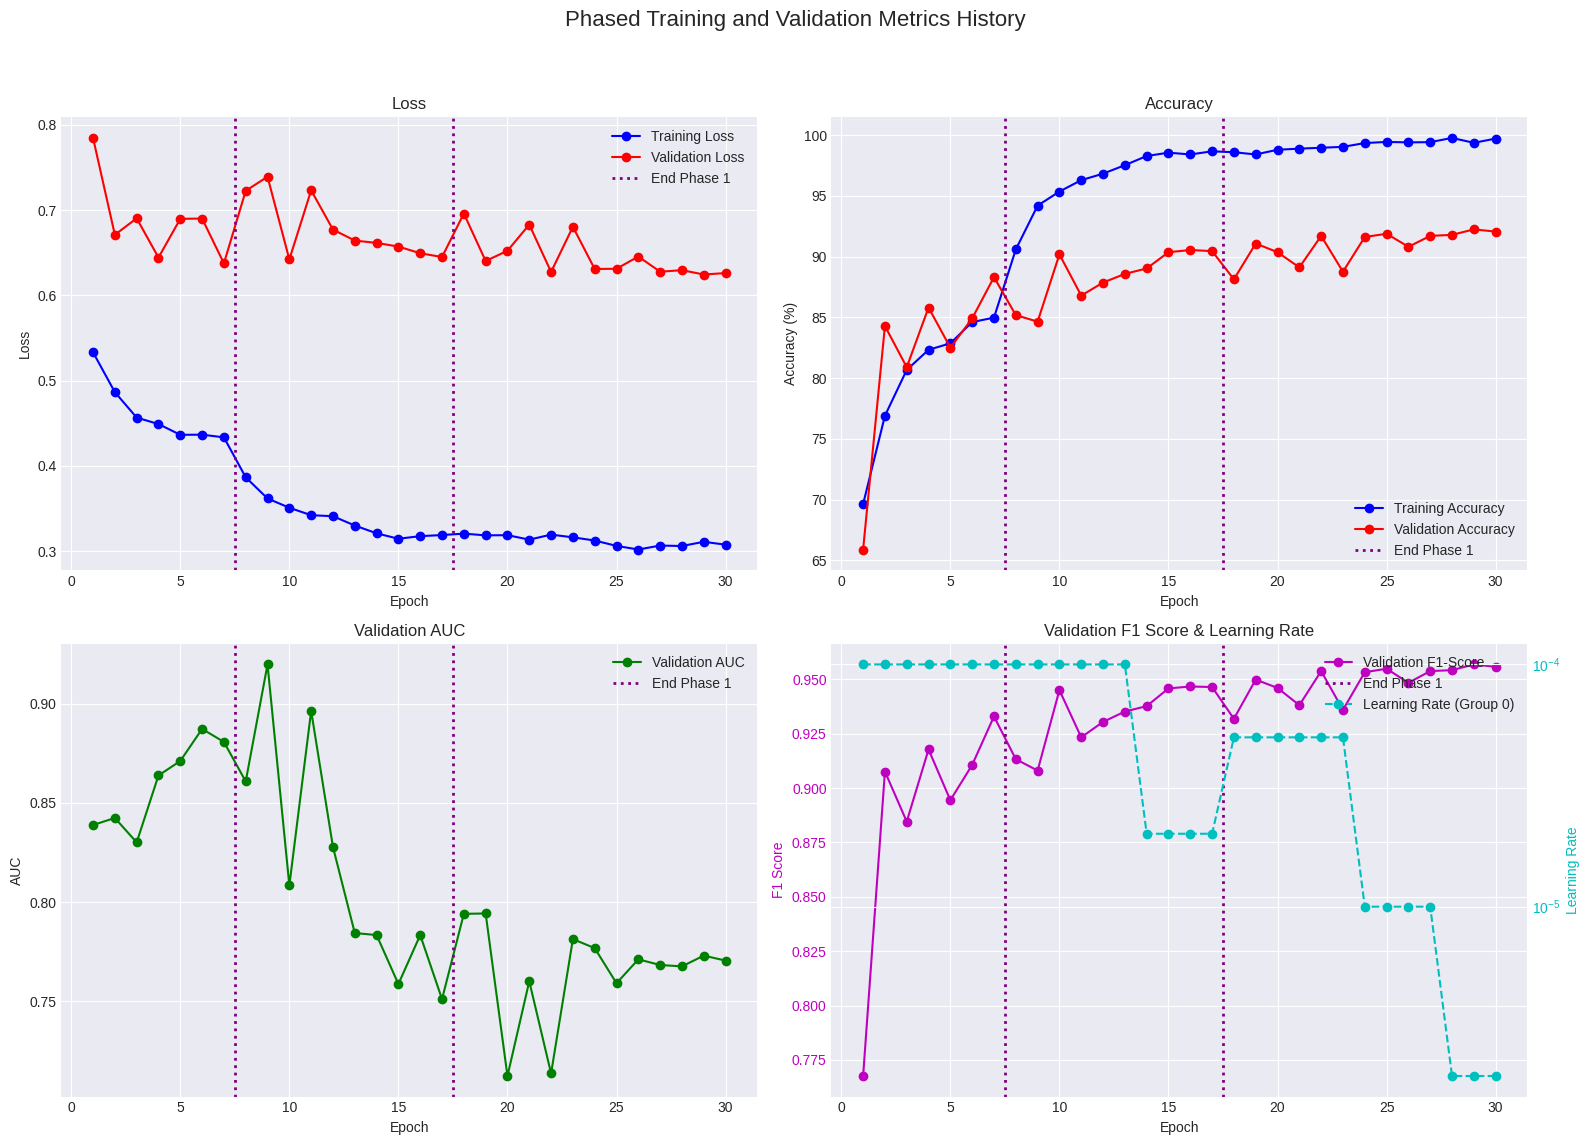


Phased training history saved to 'phased_training_history.csv'


In [ ]:
if history['train_loss']:
    epochs_ran = range(1, len(history['train_loss']) + 1)
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axs = plt.subplots(2, 2, figsize=(16, 12)) # Increased size
    fig.suptitle('Phased Training and Validation Metrics History', fontsize=16)

    # Helper to add phase transitions
    def plot_phase_transitions(ax, history_phases, phase_epochs_map):
        phase_starts = []
        current_phase_val = 0
        cumulative_epochs = 0
        # Determine actual epoch counts per phase from history if MAX_EPOCHS_TOTAL was hit early
        actual_phase_epochs = {1:0, 2:0, 3:0}
        for p in history_phases:
            actual_phase_epochs[p] +=1

        if actual_phase_epochs[1] > 0:
            cumulative_epochs += actual_phase_epochs[1]
            phase_starts.append(cumulative_epochs)
        if actual_phase_epochs[2] > 0:
            cumulative_epochs += actual_phase_epochs[2]
            phase_starts.append(cumulative_epochs)
        # No line needed after phase 3

        for i, start_epoch in enumerate(phase_starts):
            if i < len(phase_starts): # Don't draw for the very end
                 ax.axvline(start_epoch + 0.5, color='purple', linestyle=':', linewidth=2, label=f'End Phase {i+1}' if i==0 else None)
        if 'best_epoch_metrics' in locals() and best_epoch_metrics:
            ax.axvline(best_epoch_metrics['epoch'], color='grey', linestyle='--', label=f"Best Epoch ({best_epoch_metrics['epoch']})")


    # Loss
    axs[0, 0].plot(epochs_ran, history['train_loss'], 'bo-', label='Training Loss')
    axs[0, 0].plot(epochs_ran, history['val_loss'], 'ro-', label='Validation Loss')
    plot_phase_transitions(axs[0,0], history['phase'], PHASE_EPOCHS)
    axs[0, 0].set_title('Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Accuracy
    axs[0, 1].plot(epochs_ran, [a*100 for a in history['train_acc']], 'bo-', label='Training Accuracy')
    axs[0, 1].plot(epochs_ran, [a*100 for a in history['val_acc']], 'ro-', label='Validation Accuracy')
    plot_phase_transitions(axs[0,1], history['phase'], PHASE_EPOCHS)
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Accuracy (%)')
    axs[0, 1].legend()

    # AUC
    axs[1, 0].plot(epochs_ran, history['auc'], 'go-', label='Validation AUC')
    plot_phase_transitions(axs[1,0], history['phase'], PHASE_EPOCHS)
    axs[1, 0].set_title('Validation AUC')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('AUC')
    axs[1, 0].legend()

    # Learning Rate and F1 Score
    ax_f1 = axs[1, 1]
    ax_lr = axs[1, 1].twinx()
    ax_f1.plot(epochs_ran, history['f1'], 'mo-', label='Validation F1-Score')
    ax_lr.plot(epochs_ran, history['learning_rate'], 'co--', label='Learning Rate (Group 0)')
    plot_phase_transitions(axs[1,1], history['phase'], PHASE_EPOCHS)
    ax_f1.set_xlabel('Epoch')
    ax_f1.set_ylabel('F1 Score', color='m')
    ax_lr.set_ylabel('Learning Rate', color='c')
    ax_f1.tick_params(axis='y', labelcolor='m')
    ax_lr.tick_params(axis='y', labelcolor='c')
    ax_lr.set_yscale('log')
    lines, labels_ = ax_f1.get_legend_handles_labels()
    lines2, labels2_ = ax_lr.get_legend_handles_labels()
    ax_lr.legend(lines + lines2, labels_ + labels2_, loc='best')
    axs[1, 1].set_title('Validation F1 Score & Learning Rate')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    history_df = pd.DataFrame(history)
    history_df.index = history_df.index + 1
    history_df.to_csv("phased_training_history.csv", index_label="Epoch")
    print("\nPhased training history saved to 'phased_training_history.csv'")
else:
    print("\nNo training history to plot.")

#Final Evaluation on Test Set

**This section evaluates the performance of the best saved model on the unseen test set to get a final, unbiased measure of its generalization ability.**



---



**Model in Eval Mode** (model.eval()): Ensures dropout and batch norm layers behave correctly for inference.

Iterating through test_dataloader: (Unpacking inputs, labels, magnifications).

Inference: Forward pass is done within torch.no_grad() and autocast.

Metrics Calculation: Accuracy, AUC, Precision, Recall, F1-score are calculated for the test set.

Classification Report: A detailed sklearn.metrics.classification_report is printed, showing precision, recall, and F1-score per class.

Confusion Matrix: A heatmap of the confusion matrix is plotted using seaborn for a visual representation of true vs. predicted classes.

Model Summary (Final): A torchinfo.summary(model, input_size=...) is printed.


Evaluating Test Set:   0%|          | 0/43 [00:00<?, ?batch/s]


--- Test Set Evaluation Results (Best Phased Model) ---
  Accuracy:  79.07%
  AUC:       0.8048
  Precision: 0.7847
  Recall:    0.8496
  F1 Score:  0.8159

Classification Report (Test Set):
              precision    recall  f1-score   support

      benign       0.80      0.72      0.76       614
   malignant       0.78      0.85      0.82       738

    accuracy                           0.79      1352
   macro avg       0.79      0.78      0.79      1352
weighted avg       0.79      0.79      0.79      1352



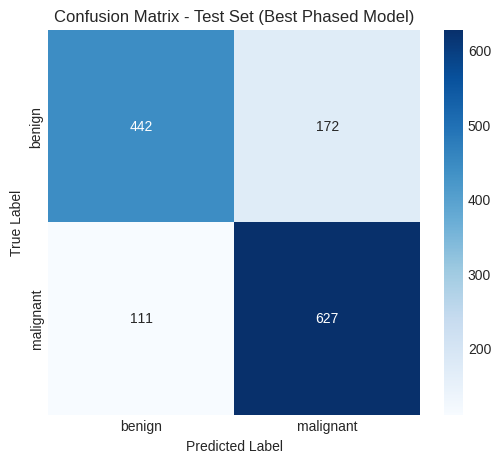

In [ ]:
# --- Final Evaluation on Test Set ---
# Model should already be loaded with best_model_state if training occurred.
# If not, load from checkpoint:
# checkpoint = torch.load("best_phased_model_checkpoint.pth", map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# print("Loaded best model from checkpoint for final testing.")

model.eval()
all_preds_test, all_labels_test, all_probs_test = [], [], []
test_pbar = tqdm(test_dataloader, desc="Evaluating Test Set", unit="batch", leave=False)

with torch.no_grad():
    for inputs, labels in test_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=torch.cuda.is_available()):
            outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)
        all_preds_test.extend(predicted.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())
        all_probs_test.extend(probs.cpu().numpy()[:, 1])

if not all_labels_test or not all_preds_test:
    print("ERROR: No predictions or labels from test set.")
else:
    test_accuracy = accuracy_score(all_labels_test, all_preds_test)
    test_precision = precision_score(all_labels_test, all_preds_test, zero_division=0)
    test_recall = recall_score(all_labels_test, all_preds_test, zero_division=0)
    test_f1 = f1_score(all_labels_test, all_preds_test, zero_division=0)
    test_auc = 0.0
    if len(np.unique(all_labels_test)) > 1:
        test_auc = roc_auc_score(all_labels_test, all_probs_test)
    else:
        print("Warning: Only one class in test set labels. AUC set to 0.")

    print("\n--- Test Set Evaluation Results (Best Phased Model) ---")
    print(f"  Accuracy:  {test_accuracy * 100:.2f}%")
    print(f"  AUC:       {test_auc:.4f}")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall:    {test_recall:.4f}")
    print(f"  F1 Score:  {test_f1:.4f}")

    print("\nClassification Report (Test Set):")
    # Ensure le.classes_ is available and correct
    target_names_report = le.classes_ if hasattr(le, 'classes_') and le.classes_ is not None else ['Class 0', 'Class 1']
    print(classification_report(all_labels_test, all_preds_test, target_names=target_names_report, zero_division=0))

    cm = confusion_matrix(all_labels_test, all_preds_test)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names_report, yticklabels=target_names_report)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Test Set (Best Phased Model)')
    plt.show()

#How the model looks

In [ ]:
print(model)


HybridModel(
  (effnet_feature_extractor): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running

In [ ]:
input_size = (1, 3, 224, 224) # (batch_size, channels, height, width)
summary(model, input_size=input_size)

Layer (type:depth-idx)                                  Output Shape              Param #
HybridModel                                             [1, 2]                    --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 24, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 24, 112, 112]         648
│    │    └─BatchNorm2d: 3-2                            [1, 24, 112, 112]         48
│    │    └─SiLU: 3-3                                   [1, 24, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 24, 112, 112]         --
│    │    └─FusedMBConv: 3-4                            [1, 24, 112, 112]         5,232
│    │    └─FusedMBConv: 3-5                            [1, 24, 112, 112]         5,232
│    └─Sequential: 2-3                                  [1, 48, 56, 56]           --
│    │    └─FusedMBConv: 3-6                         

#Final interpretation

***A. Training Performance:***

The HybridModel, combining features from pre-trained EfficientNetV2-S and ViT-B/16, was trained using a phased approach over 30 epochs.

**Phase 1**(Head Training, Epochs 1-7): The model was trained with frozen backbones, focusing on adapting the fusion and classifier layers. During this phase, the validation AUC showed consistent improvement, reaching a peak of 0.8874 at Epoch 6. This demonstrated the effectiveness of the pre-trained features and the custom head architecture in learning discriminative patterns from the BreaKHis dataset. Training accuracy climbed to approximately 85%.

**Phase 2** (Partial Backbone Fine-tuning, Epochs 8-17): In this phase, later layers of both backbones were unfrozen and trained with a reduced learning rate (e.g., head LR 1e-4, backbone LR 2e-5). This phase yielded the overall best model performance, achieving a peak validation AUC of 0.9199 at Epoch 9. This significant jump from the Phase 1 peak indicates that fine-tuning a subset of the backbone parameters allowed the model to learn more task-specific features, leading to improved generalization on the validation set. Training accuracy continued to increase, reaching over 98%, suggesting strong fitting to the training data. The learning rate scheduler reduced the learning rate for the head parameters at Epoch 14 due to a plateau in Val AUC improvement.

**Phase 3** (Full Backbone Fine-tuning, Epochs 18-30): All backbone layers were unfrozen, and even smaller learning rates were applied (e.g., head LR 5e-5, backbone LR 5e-6). Despite the increased model capacity and continued training, the validation AUC did not surpass the peak achieved in Phase 2, fluctuating in the 0.70-0.79 range. Training accuracy remained very high (around 99%). The learning rate scheduler triggered multiple times in this phase.

**Early Stopping Observation**: Although early stopping was configured with a patience of 7 epochs, it was effectively disabled for this run (the break statement was commented out). If active, training would have likely concluded around Epoch 16, after the peak at Epoch 9 was not surpassed for 7 subsequent epochs. The decision to continue training allowed for observation of model behavior under prolonged full fine-tuning.

**Best Checkpoint**: The best performing model, based on validation AUC, was saved from Epoch 9 (during Phase 2), with a Val AUC of 0.9199, Val Accuracy of 84.64%, Precision of 0.9659, Recall of 0.8567, and F1-score of 0.9080.


---


***B. Test Set Evaluation:***

The best model (from Epoch 9, Phase 2) was evaluated on the held-out test set to assess its final generalization performance.

The model achieved:

Test Accuracy: 79.07%

Test AUC: 0.8048

Test Precision (for malignant): 0.7847

Test Recall (for malignant): 0.8496

Test F1-Score (for malignant): 0.8159

**Discussion of Test Results:**

The test AUC of 0.8048 is a solid result, indicating good generalization capability.

There is a generalization gap observed between the peak validation AUC (0.9199) and the test AUC (0.8048). This is common in machine learning and suggests that the model, while performing well, might have learned some patterns specific to the validation set that did not fully translate to the test set. This could also be due to inherent differences in the data distribution between the validation and test splits, despite careful group-based splitting.

The classification report and confusion matrix (refer to plotted figures) provide further insight into per-class performance, showing a reasonable balance in predicting benign and malignant cases, though with slightly higher recall for the malignant class.


---


***C. Overall Conclusion from this Run:***

The phased training strategy was effective, with partial backbone fine-tuning (Phase 2) yielding the best validation performance.

The HybridModel demonstrated a strong ability to learn from the BreaKHis dataset, achieving a peak validation AUC of approximately 0.92.

Full fine-tuning of all backbone layers (Phase 3) did not lead to further improvements in validation AUC for this specific run and hyperparameter configuration, suggesting that either the optimal feature representation was achieved in Phase 2, or Phase 3 might require even more nuanced tuning or longer training under different conditions.

The final test set performance (AUC 0.8048) is respectable and demonstrates practical utility, though the generalization gap warrants consideration for future work (e.g., exploring more robust regularization, different data augmentation strategies, or cross-validation).